In [1]:
#pandas: manejo de datos
#numpy: integración numérica
#matplotlib: visualización científica

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/batteries1/B0005_descarga.csv
/kaggle/input/data-batteries/B0006.mat
/kaggle/input/data-batteries/B0005.mat
/kaggle/input/data-batteries/B0007.mat
/kaggle/input/data-batteries/B0018.mat


In [3]:
# Ruta del dataset cargado en Kaggle
DATA_PATH = '/kaggle/input/batteries1/'

# Cargamos la batería B0005
df = pd.read_csv(DATA_PATH + 'B0005_descarga.csv')

df.head()


,bateria,ciclo,tiempo,voltaje,corriente,temperatura
0,B0005,1,0.000,4.191492,-0.004902,24.330034
1,B0005,1,16.781,4.190749,-0.001478,24.325993
2,B0005,1,35.703,3.974871,-2.012528,24.389085
3,B0005,1,53.781,3.951717,-2.013979,24.544752
4,B0005,1,71.922,3.934352,-2.011144,24.731385


In [4]:
# Información general del dataset
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50285 entries, 0 to 50284
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bateria      50285 non-null  object 
 1   ciclo        50285 non-null  int64  
 2   tiempo       50285 non-null  float64
 3   voltaje      50285 non-null  float64
 4   corriente    50285 non-null  float64
 5   temperatura  50285 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.3+ MB


In [5]:
# Ordenamos por ciclo y tiempo (CRÍTICO)
df = df.sort_values(by=['ciclo', 'tiempo'])

# Número de ciclos disponibles
df['ciclo'].nunique()


168

In [6]:
def calcular_capacidad_por_ciclo(df):
    """
    Calcula la capacidad descargada (Ah) por ciclo de descarga.
    """

    resultados = []

    for ciclo, datos in df.groupby('ciclo'):
        
        tiempo = datos['tiempo'].values
        corriente = datos['corriente'].values
        
        # Integración numérica de I(t)
        carga_coulomb = np.trapz(corriente, tiempo)
        
        # Conversión a Ah
        capacidad_ah = abs(carga_coulomb) / 3600
        
        resultados.append([ciclo, capacidad_ah])

    return pd.DataFrame(
        resultados,
        columns=['ciclo', 'capacidad_ah']
    )


In [7]:
df_capacidad = calcular_capacidad_por_ciclo(df)

df_capacidad.head()


,ciclo,capacidad_ah
0,1,1.862192
1,3,1.851986
2,5,1.840993
3,7,1.840881
4,9,1.840325


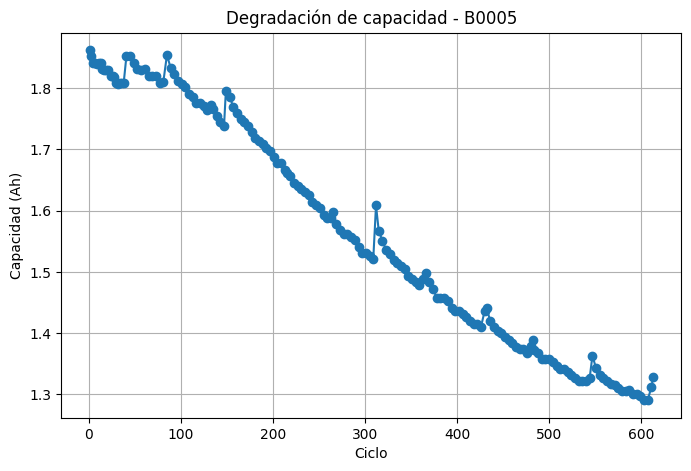

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(
    df_capacidad['ciclo'],
    df_capacidad['capacidad_ah'],
    marker='o'
)
plt.xlabel('Ciclo')
plt.ylabel('Capacidad (Ah)')
plt.title('Degradación de capacidad - B0005')
plt.grid(True)
plt.show()


In [9]:
capacidad_inicial = df_capacidad['capacidad_ah'].iloc[0]

df_capacidad['capacidad_normalizada'] = (
    df_capacidad['capacidad_ah'] / capacidad_inicial
)

df_capacidad.head()


,ciclo,capacidad_ah,capacidad_normalizada
0,1,1.862192,1.000000
1,3,1.851986,0.994519
2,5,1.840993,0.988616
3,7,1.840881,0.988556
4,9,1.840325,0.988258


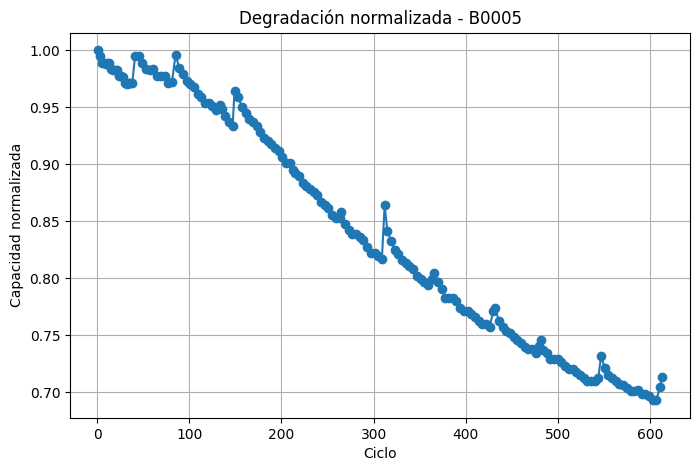

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(
    df_capacidad['ciclo'],
    df_capacidad['capacidad_normalizada'],
    marker='o'
)
plt.xlabel('Ciclo')
plt.ylabel('Capacidad normalizada')
plt.title('Degradación normalizada - B0005')
plt.grid(True)
plt.show()


## feat: cálculo de capacidad por ciclo para batería B0005


In [11]:
# Umbral de fin de vida (80 %)
EOL_THRESHOLD = 0.8

In [12]:
# Capacidad inicial (ya calculada antes)
capacidad_inicial = df_capacidad['capacidad_ah'].iloc[0]

# Capacidad umbral de EOL
capacidad_eol = EOL_THRESHOLD * capacidad_inicial

capacidad_eol


1.4897536534114808

In [13]:
# Encontrar el primer ciclo donde la capacidad cae por debajo del umbral
ciclo_eol = df_capacidad[
    df_capacidad['capacidad_ah'] <= capacidad_eol
]['ciclo'].iloc[0]

ciclo_eol


351

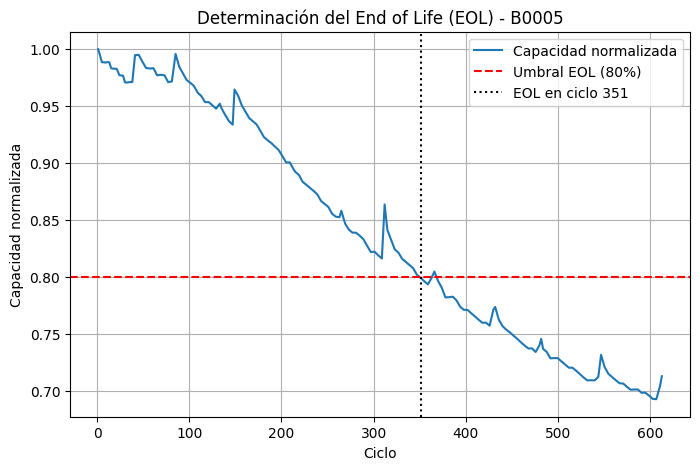

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(
    df_capacidad['ciclo'],
    df_capacidad['capacidad_normalizada'],
    label='Capacidad normalizada'
)

plt.axhline(
    y=EOL_THRESHOLD,
    color='red',
    linestyle='--',
    label='Umbral EOL (80%)'
)

plt.axvline(
    x=ciclo_eol,
    color='black',
    linestyle=':',
    label=f'EOL en ciclo {ciclo_eol}'
)

plt.xlabel('Ciclo')
plt.ylabel('Capacidad normalizada')
plt.title('Determinación del End of Life (EOL) - B0005')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Cálculo del RUL
df_capacidad['RUL'] = ciclo_eol - df_capacidad['ciclo']

# Nos quedamos solo con ciclos antes del EOL
df_capacidad = df_capacidad[df_capacidad['RUL'] >= 0]

df_capacidad.head()


,ciclo,capacidad_ah,capacidad_normalizada,RUL
0,1,1.862192,1.000000,350
1,3,1.851986,0.994519,348
2,5,1.840993,0.988616,346
3,7,1.840881,0.988556,344
4,9,1.840325,0.988258,342


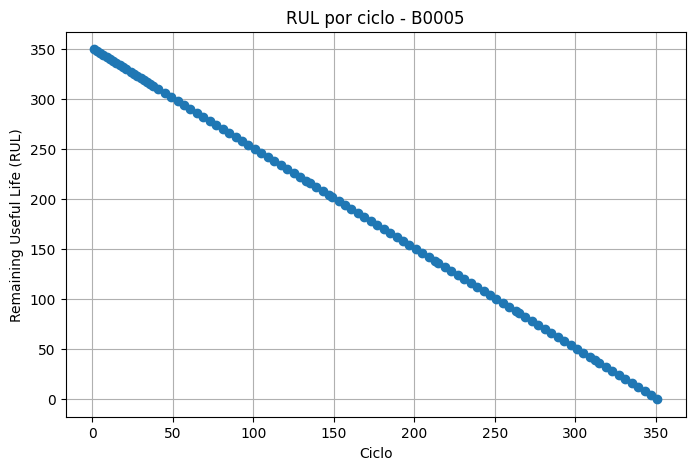

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(
    df_capacidad['ciclo'],
    df_capacidad['RUL'],
    marker='o'
)
plt.xlabel('Ciclo')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('RUL por ciclo - B0005')
plt.grid(True)
plt.show()


In [17]:
df_capacidad.head()


,ciclo,capacidad_ah,capacidad_normalizada,RUL
0,1,1.862192,1.000000,350
1,3,1.851986,0.994519,348
2,5,1.840993,0.988616,346
3,7,1.840881,0.988556,344
4,9,1.840325,0.988258,342


## feat: definición de EOL y cálculo de RUL para batería B0005


In [18]:
df_capacidad.to_csv(
    'B0005_capacidad_RUL.csv',
    index=False
)
